<h1> Experiment reflection against number of RG steps </h1>

In [9]:
#General imports
resol = 300
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.linewidth": 0.7,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
})

import sys
import numpy as np
from pathlib import Path
pi = np.pi

project_root = Path().resolve().parents[1]
sys.path.append(str(project_root))

#Local imports
from single_photon_renormalization.scripts_experiments.reflection_vs_rgstep import run_reflection_vs_rgstep

# Function to compute the converged value of a function
def final_value(y, n_avg=20):
    return np.mean(y[-n_avg:])

<h2> Execute the experiment </h2>

In [56]:
#Physical parameters
omega_A = 10*pi
Gamma = pi

#incoming photon parameters
param_photon_bis = {'delta_k': 0.05*np.pi, 'x_0': -25} 
frequency_values = np.array([omega_A, omega_A - Gamma/4, omega_A - Gamma/2])
#Time of the simulation
T = 50  

In this experiment, we assess the efficiency of the renormalization-aware parameterization. 

Given the physical parameters $\omega_A$ and $\Gamma$, we fix the frequency window to $[\Lambda_{\rm IR}, \Lambda_{\rm UV}] = [\omega_A - \Lambda, \omega_A + \Lambda]$ and use:

$$ \omega_0 = \omega_A , \quad \gamma = \frac{\Gamma}{1 + \Gamma/(\pi \Lambda)}$$

Then, we check the number of time steps in the Runge–Kutta scheme required to reach convergence of physical observables for different values of the bandwidth $\Lambda$. To do so, for each value of $\Lambda$, we examine the reflection probability as a function of the number of RG time steps, for several incoming photon frequencies.

In [98]:
#Prepare the different values of Lambda and an array of time steps
lbda_tab = np.array([5*pi, 3*pi, pi])

nb_pts_steps = 100
N_step_tab = np.unique(np.logspace(1, 4, nb_pts_steps).astype(int))
dt_tab = T / N_step_tab

Run the experiment

In [99]:
for i in range(len(lbda_tab)):
    lbda = lbda_tab[i]
    index_experiment = i + 1
    print("Running frequency window number ", index_experiment, " out of ", len(lbda_tab))
    cutoffs = {'ir_cutoff': omega_A - lbda, 'uv_cutoff': omega_A + lbda}

    #renormalized-aware parameterization of the cavity
    param_cavity = {'omega_0': omega_A, 'gamma': Gamma / (1 + Gamma/(pi*lbda)), 'L': 100}

    #run the experiment
    data_rows = run_reflection_vs_rgstep(param_photon_bis, param_cavity, T, frequency_values, dt_tab, cutoffs, index_experiment,
                             store_results=True, progress=True)


Running frequency window number  1  out of  3


100%|██████████| 99/99 [01:04<00:00,  1.55it/s]


Running frequency window number  2  out of  3


100%|██████████| 99/99 [00:52<00:00,  1.88it/s]


Running frequency window number  3  out of  3


100%|██████████| 99/99 [00:41<00:00,  2.39it/s]


<h2> Plot the results </h2>

Recover the data

In [115]:
index_experiment = 1

file_data = f"../results/csv_files/reflection_vs_rgstep_{index_experiment}.csv"
df = pd.read_csv(file_data)

#Prepare the three curves corresponding to the three photonic frequencies
dt_tab = np.unique(df['dt'].values)
N_step_tab = np.sort(np.array((T / dt_tab).astype(int)))

reflection_tab_omegap_1 = file_data = df[np.isclose(df['omega_p'],frequency_values[0], atol=1e-3)]['final_reflection'].values
reflection_tab_omegap_2 = file_data = df[np.isclose(df['omega_p'],frequency_values[1], atol=1e-3)]['final_reflection'].values
reflection_tab_omegap_3 = file_data = df[np.isclose(df['omega_p'],frequency_values[2], atol=1e-3)]['final_reflection'].values

curves = [reflection_tab_omegap_1, reflection_tab_omegap_2, reflection_tab_omegap_3]

#Get the time step required to reach convergence for each curve
conv_index_tab = np.array([np.where(np.abs(reflection_tab_omegap_1 - final_value(reflection_tab_omegap_1)) < 0.05 * final_value(reflection_tab_omegap_1))[0][0],
                  np.where(np.abs(reflection_tab_omegap_2 - final_value(reflection_tab_omegap_2)) < 0.05 * final_value(reflection_tab_omegap_2))[0][0],
                  np.where(np.abs(reflection_tab_omegap_3 - final_value(reflection_tab_omegap_3)) < 0.05 * final_value(reflection_tab_omegap_3))[0][0]])

conv_index = np.max(conv_index_tab)
dt_convergence = dt_tab[conv_index]
N_step_convergence = N_step_tab[conv_index]

Plot the results

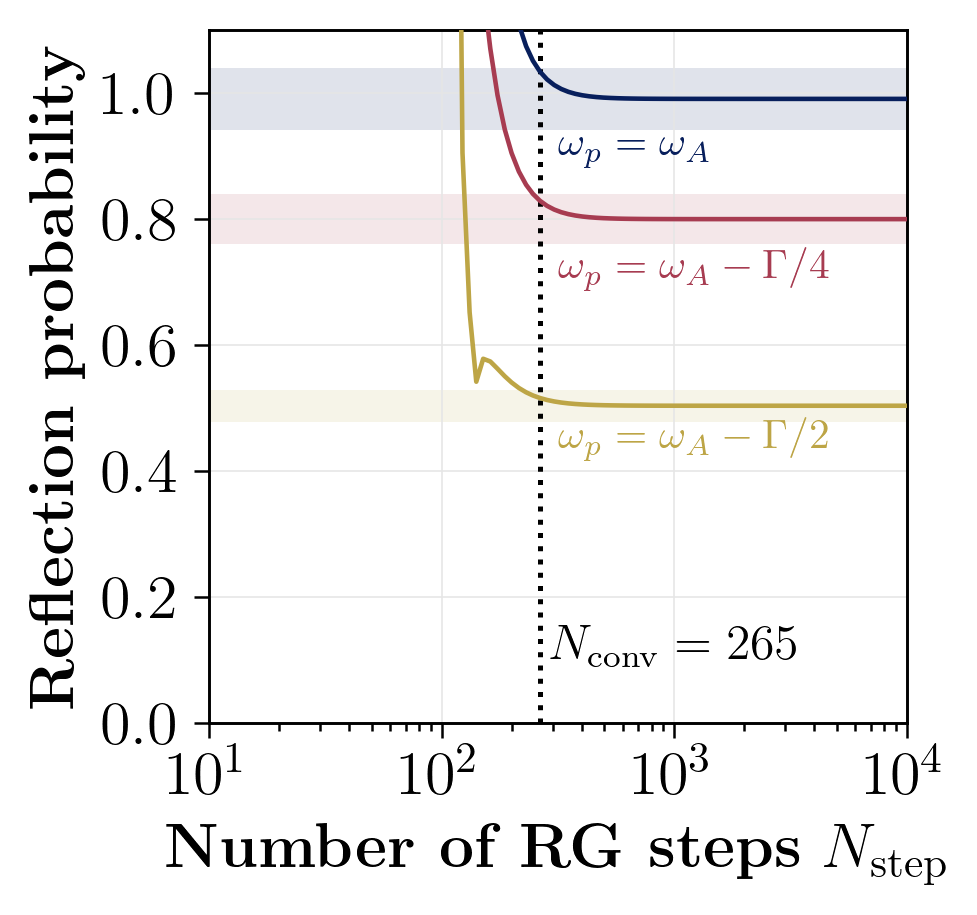

In [116]:
colors = ['#081f5c', '#a73c51', '#bda546']
labels = [
    r'$\omega_p = \omega_A$',
    r'$\omega_p = \omega_A - \Gamma/4$',
    r'$\omega_p = \omega_A - \Gamma/2$'
]
label_pos = [0.91, 0.72, 0.45]

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

#Plot the three curves
for i, (c, lab) in enumerate(zip(colors, labels)):
    
    #curve
    y = curves[i]
    ax.plot(N_step_tab, y, '-', color=c, lw=1.1, label=lab, zorder=3)

    # 5% band around the converged value
    y_inf = final_value(y)
    y_low  = 0.95 * y_inf
    y_high = 1.05 * y_inf
    ax.fill_between(N_step_tab,y_low,y_high,color=c,alpha=0.12,linewidth=0, zorder=1)

# Vertical line at convergence point
ax.axvline(N_step_convergence,color='black',ls=':',lw=1.2, zorder=2)
ax.text(
    N_step_convergence * 1.1,
    0.1,
    f'$N_{{\\rm conv}} = {int(N_step_convergence)}$',
    fontsize=12,
    color='black'
)

# Labels and limits
ax.set_xlabel(r'\textbf{Number of RG steps} $N_{\rm step}$', fontsize=10)
ax.set_ylabel(r'\textbf{Reflection probability}', fontsize=10)
ax.set_xscale("log")
ax.set_xlim(1e1,1e4)
ax.set_xticks([1e1,1e2,1e3,1e4])
ax.set_ylim(0,1.1)
ax.grid(color='0.9', linestyle='-', linewidth=0.4)

# Indicate frequency of the photons
for label_pos, lab, col in zip(label_pos, labels, colors):

    ax.text(
        0.5,                 
        label_pos,                
        lab,
        color=col,
        fontsize=10,
        va='center',
        ha='left',
        transform=ax.get_yaxis_transform()
    )

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.savefig("../results/fig/experiment_convergence_RG_step_"+str(index_experiment)+".pdf", bbox_inches="tight")
plt.show()